# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports,-Definitions" data-toc-modified-id="Imports,-Definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports, Definitions</a></div><div class="lev1 toc-item"><a href="#Dijkstra" data-toc-modified-id="Dijkstra-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dijkstra</a></div><div class="lev1 toc-item"><a href="#A*" data-toc-modified-id="A*-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A*</a></div>

[Draw a Map][map]

Make a map that has a few different rooms; make some rooms harder to traverse than others. Use this to show how Dijkstra prefers shorter paths first. With A\* on this map, not only will it go through the rooms that are easier first, it won't expand all directions in the room but just the direction towards the goal.

[map]: https://neighthan.github.io/graphs_and_games/create_map.html

# Imports, Definitions

In [1]:
import numpy as np
import pandas as pd
from heapq import heappush, heappop
from ast import literal_eval
from IPython import display
import matplotlib.pyplot as plt
from skvideo.io import FFmpegWriter
from scipy.ndimage.interpolation import zoom
from matplotlib.colors import ListedColormap
from collections import namedtuple
import pickle

%matplotlib inline

/home/nhunt/anaconda3/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [2]:
grid_cell_types = ['START', 'GOAL', 'FRINGE', 'EXPANDED', 'PATH', 'ROAD', 'GRASSY', 'FOREST', 'ROCKY']
grid_colors = ['green', 'red', 'lightblue', 'blue', 'yellow', 'sandybrown', 'lightgreen', 'darkgreen', 'grey']

# just for fancy dotted access
GridValues = namedtuple('GridValues', grid_cell_types)
GridValue = namedtuple('GridValue', ['value', 'name', 'color'])
grid_values = GridValues(*[GridValue(-(i + 1), grid_cell_types[i], grid_colors[i]) for i in range(len(grid_colors))])

In [3]:
class Terrain(object):
    def __init__(self, saved_name=''):
        """
        :param terrain_types: must be in order from smallest to largest by their weight
        """
        if saved_name:
            with open(saved_name, 'rb') as f:
                self.grid, self.terrain_types = pickle.load(f)
        else:
            self.grid = np.array(literal_eval(input('Paste map data here')))
            display.clear_output()
            self.terrain_types = literal_eval(input('Paste terrain types here'))
            display.clear_output()

    def __cmap__(self, types):
        return ListedColormap(list(map(lambda terrain_type: grid_colors[grid_cell_types.index(terrain_type)], types)))

    def show_terrain(self, grid=None, types=None):
        grid = grid if grid is not None else self.grid
        types = types or self.terrain_types
        
        unique_vals = np.unique(grid)
        grid = pd.DataFrame(grid).replace({unique_vals[i]: i for i in range(len(unique_vals))}).values

        plt.figure(figsize=(20, 10))
        img = plt.matshow(grid, cmap=self.__cmap__(types), fignum=1, vmin=-0.5, vmax=len(unique_vals)-0.5)
        cbar = plt.colorbar(ticks=np.arange(0, len(unique_vals)))
        cbar.set_ticklabels(types)

    def show_path(self, path):
        grid = self.grid.copy()
        for node in path:
            grid[node] = -1
        self.show_terrain(grid, ['PATH'] + self.terrain_types)

    def __repr__(self):
        self.show_terrain()
        return ''

    def save(self, name):
        with open(name, 'wb') as f:
            pickle.dump((self.grid, self.terrain_types), f)

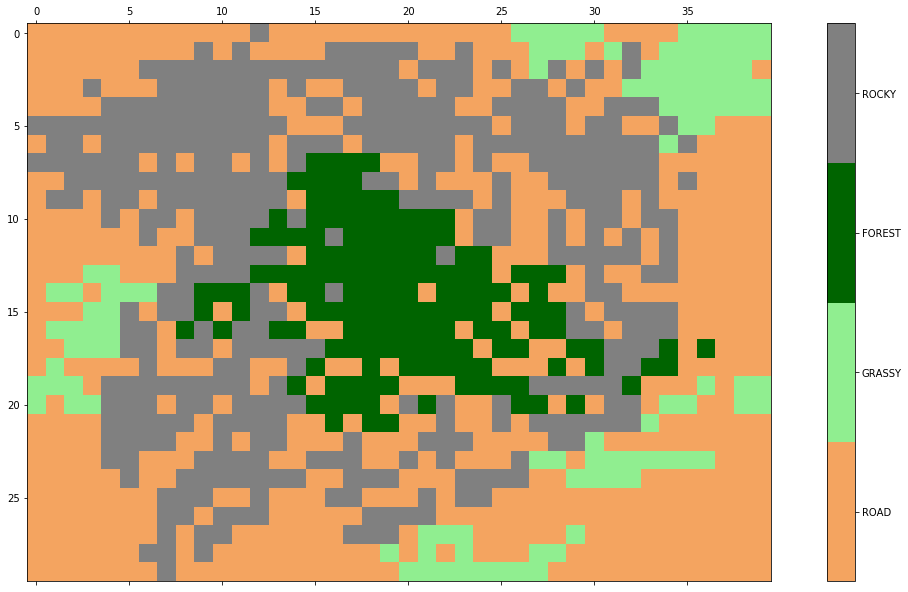

In [4]:
terrain = Terrain('maps/test1.pkl')
terrain

# Dijkstra

Dijkstra's algorithm only works on graphs with non-negative weights. There are other algorithms that you can use instead of any of the edge's might have a negative weight.



(Here we don't use the decrease-key version of Dijkstra; see a [StackOverflow answer][so] for a comparison of using/not using decrease key for different sorts of priority queues and a [paper][paper] for more in-depth results comparing different versions of Dijkstra for empirical, not only asymptotic, performance)

[so]: https://stackoverflow.com/questions/9255620/why-does-dijkstras-algorithm-use-decrease-key
[paper]: http://www3.cs.stonybrook.edu/~rezaul/papers/TR-07-54.pdf

In [5]:
up = np.array([-1, 0])
down = np.array([1, 0])
left = np.array([0, -1])
right = np.array([0, 1])
directions = [up, down, left, right]

def get_neighbors(node_loc, grid, weighted=True):
    upper_bounds = np.array(grid.shape) - 1
    lower_bounds = np.array([0, 0])
    
    neighbors = []
    for direction in directions:
        neighbor = np.minimum(np.maximum(node_loc + direction, lower_bounds), upper_bounds)
        
        if weighted:
            if not np.all(neighbor == node_loc):
                neighbors.append((tuple(neighbor), grid[tuple(neighbor)]))
        else:
            if not np.all(neighbor == node_loc) and grid[tuple(neighbor)] != grid_values.WALL.value:
                neighbors.append(tuple(neighbor))
    return neighbors

In [6]:
def get_path(goal, parents):
    path = []
    parent = goal
    while parent is not None:
        path.append(parent)
        parent, _ = parents[parent]
    path.reverse()
    return path

In [7]:
class Plot(object):
    def __init__(self):
        pass

In [12]:
def dijkstra_a_star(grid, start, goal, plot='', video_size=(600, 600), video_path='movies/search.mp4'):
    if type(grid) == Terrain:
        terrain = grid
        grid = terrain.grid
    else:
        terrain = None

    heap = []
    expanded = set()
    parents = {}
    current_node = start
    path_cost = 0
    parent = None
    
    fringe_alpha = 0.7
    expanded_alpha = 0.2
    
    # plot before hook
    assert terrain is not None, "Must pass in terrain types to create a plot."
    unique_vals = np.unique(grid)
    unique_vals = np.unique(grid)
    plotting_grid = pd.DataFrame(grid).replace({unique_vals[i]: i for i in range(len(unique_vals))}).values # we'll modify this one to use in the plots
    # plotting_grid[start] = grid_values.START.value
    # plotting_grid[goal] = grid_values.GOAL.value
    plotting_grid = terrain.__cmap__(terrain.terrain_types)(plotting_grid)
    zoom_aspect = (video_size[0] / grid.shape[0], video_size[1] / grid.shape[1], 1)
    frames = []
    writer = FFmpegWriter(video_path)


    while True:
        parents[current_node] = parent
        expanded.add(current_node)

        if current_node == goal:
            break

        neighbors = ((neighbor, weight) for (neighbor, weight) in get_neighbors(current_node, grid) if neighbor not in expanded)
        for (neighbor, weight) in neighbors:
            heappush(heap, (path_cost + weight, neighbor, current_node))
        
        # plot during hook
        if plot:
            plotting_grid[current_node][3] = expanded_alpha
            
            for (neighbor, _) in neighbors:
                plotting_grid[neighbor][3] = fringe_alpha
            
            if plot == 'during': # nbagg is faster but it often doesn't leave a graph behind and its window doesn't look as nice
                img.set_data(plotting_grid)
                display.display(plt.gcf())
                display.clear_output(wait=True)
            elif plot == 'after':
                writer.writeFrame(zoom(plotting_grid, zoom_aspect, order=0) * 255)

        while current_node in expanded:
            path_cost, current_node, parent = heappop(heap)
    
    # plot after hook
    if plot == 'after':
        writer.close()
    return get_path(goal, parents)

In [11]:
grid = terrain.grid
start = (0, 0)
goal = tuple(np.array(terrain.grid.shape)-1)
plot='after'
terrain_types=terrain.terrain_types
video_size = (600, 600)

In [12]:
heap = []
expanded = set()
parents = {}
current_node = start
path_cost = 0
parent = None
    
# plot before hook
assert terrain_types is not None, "Must pass in terrain types to create a plot."
unique_vals = np.unique(grid)
plotting_grid = pd.DataFrame(grid).replace({unique_vals[i]: i for i in range(len(unique_vals))}).values # we'll modify this one to use in the plots
# plotting_grid[start] = grid_values.START.value
# plotting_grid[goal] = grid_values.GOAL.value
plotting_grid = terrain.__cmap__(terrain.terrain_types)(plotting_grid)
zoom_aspect = (video_size[0] / grid.shape[0], video_size[1] / grid.shape[1])
frames = []

In [13]:
parents[current_node] = parent
expanded.add(current_node)

# if current_node == goal:
#     break

neighbors = [(neighbor, weight) for (neighbor, weight) in get_neighbors(current_node, grid) if neighbor not in expanded]
for (neighbor, weight) in neighbors:
    heappush(heap, (path_cost + weight, neighbor, current_node))

# plot during hook
if plot:
    if current_node != start:
        plotting_grid[current_node][3] = 0.3 #grid_values.EXPANDED.value

    for (neighbor, _) in neighbors:
        if neighbor != goal:
            plotting_grid[neighbor][3] = 0.8 # grid_values.FRINGE.value

    if plot == 'during': # nbagg is faster but it often doesn't leave a graph behind and its window doesn't look as nice
        img.set_data(plotting_grid)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    elif plot == 'after':
        frames.append(plotting_grid.copy())
#         frames.append(zoom(plotting_grid, zoom_aspect, order=0))

while current_node in expanded:
    path_cost, current_node, parent = heappop(heap)

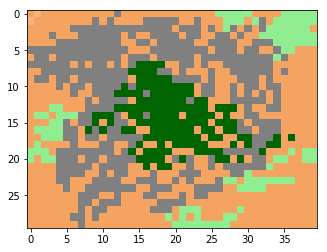

In [16]:
plt.imshow(frames[0])

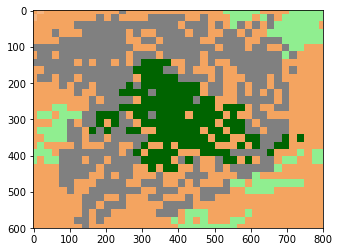

In [19]:
plt.imshow(zoom(frames[0], (20, 20, 1), order=0))

In [2]:
plt.matshow(frames[0], cmap=ListedColormap([grid_colors[grid_cell_types.index(terrain_type)] for terrain_type in ['EXPANDED', 'FRINGE', 'GOAL', 'START'] + terrain_types]))

NameError: name 'plt' is not defined

In [ ]:
while True:
    parents[current_node] = parent
    expanded.add(current_node)

    if current_node == goal:
        break

    neighbors = get_neighbors(current_node, grid)
    for (neighbor, weight) in neighbors:
        if neighbor not in expanded:
            heappush(heap, (path_cost + weight, neighbor, current_node))

    # plot during hook
    if plot:
        if current_node != start:
            plotting_grid[current_node] = grid_values.EXPANDED.value

        for (neighbor, _) in neighbors:
            if neighbor != goal:
                plotting_grid[neighbor] = grid_values.FRINGE.value

        if plot == 'during': # nbagg is faster but it often doesn't leave a graph behind and its window doesn't look as nice
            img.set_data(plotting_grid)
            display.display(plt.gcf())
            display.clear_output(wait=True)
        elif plot == 'after':
            frames.append(zoom(plotting_grid, zoom_aspect, order=0))

    while current_node in expanded:
        path_cost, current_node, parent = heappop(heap)

# plot after hook
if plot == 'after':
    frames = np.dstack(frames).transpose(2, 0, 1)
    cmap = ListedColormap([grid_colors[grid_cell_types.index(terrain_type)] for terrain_type in ['START', 'GOAL', 'FRINGE', 'EXPANDED'] + terrain_types])
    return frames, cmap
    with FFmpegWriter(video_path) as writer:
        batch_size = 100
        for i in range(np.ceil(len(frames) / batch_size).astype(int)):
            writer.writeFrame(cmap(frames[i * batch_size : (i + 1) * batch_size]) * 255)

In [19]:
[grid_colors[grid_cell_types.index(terrain_type)] for terrain_type in ['START', 'GOAL', 'FRINGE', 'EXPANDED'] + terrain.terrain_types]

['green',
 'red',
 'lightblue',
 'blue',
 'sandybrown',
 'lightgreen',
 'darkgreen',
 'grey']

In [13]:
frames.shape

(1199, 600, 600)

In [ ]:
cmap

In [30]:
grid_values.START.value

-1

In [28]:
np.unique(frames[3])

array([-4, -3, -2,  5,  8, 13, 18])

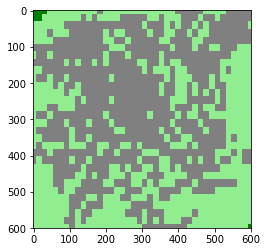

In [26]:
plt.imshow(cmap(frames[1]))

In [ ]:
# try to write the video in chunks? Is there a better way to do the conversion?
# get a video writer, then write the frames in batches (instead of storing the batches and then writing all of them at the end)

In [ ]:
def heuristic(node, goal, max_weight):
    

In [ ]:
node = (0, 0)
goal = (10, 10)
max_weight = 17

In [15]:
from matplotlib import colors

In [ ]:
colors.rgb_to_hsv()

In [13]:
path = dijkstra_a_star(terrain, (0, 0), tuple(np.array(terrain.grid.shape)-1), plot='after', video_path='movies/dijkstra.mp4')

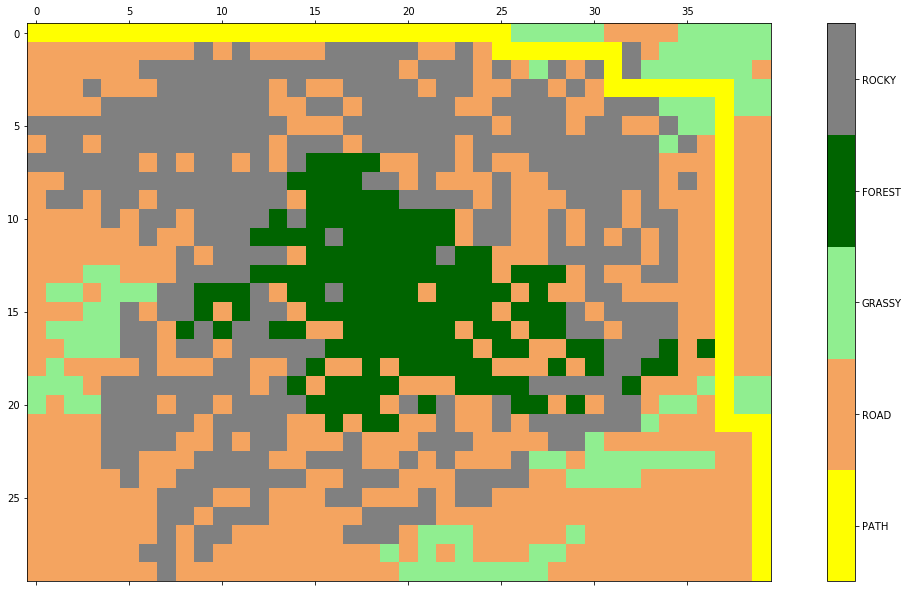

In [14]:
terrain.show_path(path)

In [ ]:
r = np.random.rand((100, 100, 100, 3))

<video controls src='movies/dijkstra.mp4'>

# A\*

In [14]:
def a_star(grid, start, goal):
    pass